In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Veri seti yollarını güncelle
data_dir = '/content/drive/My Drive/dataset/Dataset/AID'

Found 8000 images belonging to 30 classes.
Found 2000 images belonging to 30 classes.
171446536/171446536 [==============================] - 5s 0us/step
Epoch 1/10
250/250 [==============================] - 4740s 19s/step - loss: 0.6915 - categorical_accuracy: 0.8115 - precision: 0.8823 - recall: 0.7728 - f1_score: 0.8239 - val_loss: 7.3154 - val_categorical_accuracy: 0.0343 - val_precision: 0.0389 - val_recall: 0.0338 - val_f1_score: 0.0362
Epoch 2/10
250/250 [==============================] - 124s 494ms/step - loss: 0.0821 - categorical_accuracy: 0.9764 - precision: 0.9813 - recall: 0.9700 - f1_score: 0.9756 - val_loss: 6.7330 - val_categorical_accuracy: 0.0353 - val_precision: 0.0363 - val_recall: 0.0338 - val_f1_score: 0.0350
Epoch 3/10
250/250 [==============================] - 113s 452ms/step - loss: 0.0383 - categorical_accuracy: 0.9895 - precision: 0.9910 - recall: 0.9874 - f1_score: 0.9892 - val_loss: 2.7346 - val_categorical_accuracy: 0.4088 - val_precision: 0.4745 - val_reca

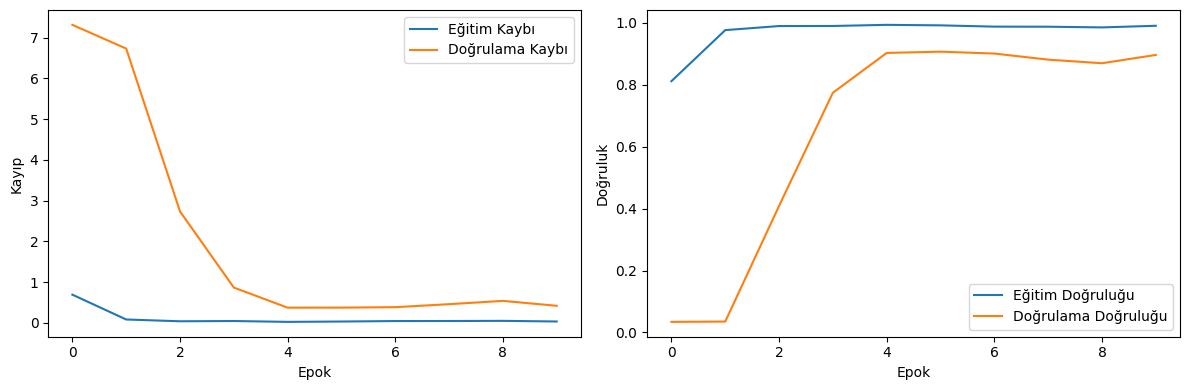

1/1 [==============================] - 2s 2s/step
Resim 1:
Tahmin edilen sınıf: Port
Gerçek sınıf: Port
1/1 [==============================] - 0s 32ms/step
Resim 2:
Tahmin edilen sınıf: Industrial
Gerçek sınıf: Industrial
1/1 [==============================] - 0s 27ms/step
Resim 3:
Tahmin edilen sınıf: RailwayStation
Gerçek sınıf: RailwayStation
1/1 [==============================] - 0s 27ms/step
Resim 4:
Tahmin edilen sınıf: StorageTanks
Gerçek sınıf: StorageTanks
1/1 [==============================] - 0s 27ms/step
Resim 5:
Tahmin edilen sınıf: Bridge
Gerçek sınıf: Bridge


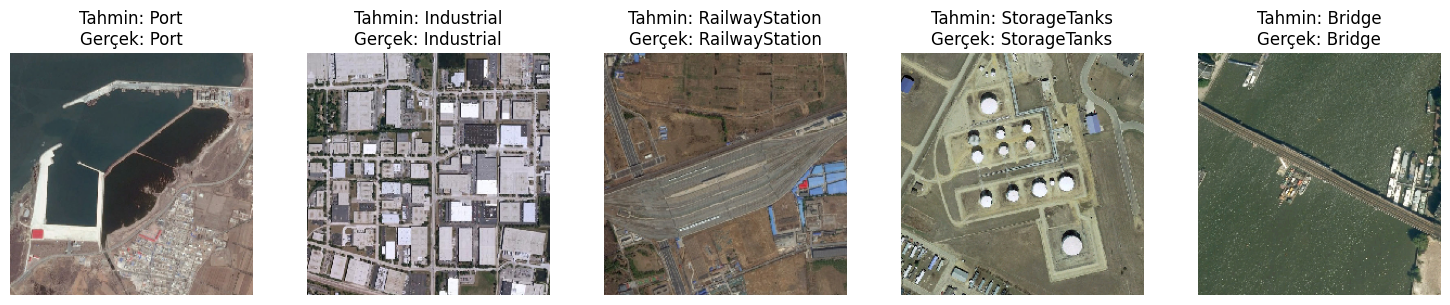

In [4]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Özel F1Score sınıfı tanımlama
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision_result = self.precision.result()
        recall_result = self.recall.result()
        return 2 * ((precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Veri yolu
image_width, image_height = 224, 224
batch_size = 32
num_classes = 30
epochs = 10

# Veri setini oluşturma (Veri artırma olmadan)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Eğitim seti
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Eğitim setini seçmek için
)

# Doğrulama seti
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Doğrulama setini seçmek için
)

# ResNet101 modelini kullanarak transfer learning
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(), Precision(), Recall(), F1Score()]
)

# Modeli eğit
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Doğrulama veri seti üzerinde tahminler yapma
validation_loss, validation_acc, validation_prec, validation_rec, validation_f1 = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)

print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_acc}')
print(f'Validation Precision: {validation_prec}')
print(f'Validation Recall: {validation_rec}')
print(f'Validation F1 Score: {validation_f1}')

# Eğitim ve doğrulama süreçlerinin görselleştirilmesi
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_categorical_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()



import numpy as np
from tensorflow.keras.preprocessing import image
import os
test_image_paths = np.random.choice(validation_generator.filepaths, size=5, replace=False)


class_labels = list(validation_generator.class_indices.keys())
fig, axes = plt.subplots(1, 5, figsize=(15, 3))


for i, random_test_image_path in enumerate(test_image_paths):
    # Seçilen resmi yükle ve modele uygun hale getir
    img = image.load_img(random_test_image_path, target_size=(image_width, image_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Resmi normalleştir

    # Model üzerinde tahmin yap
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Gerçek sınıfı bul
    true_class = os.path.basename(os.path.dirname(random_test_image_path))  # Alt klasör adını al

    # Tahmin ve gerçek sınıfları yazdır
    print(f"Resim {i + 1}:")
    print("Tahmin edilen sınıf:", class_labels[predicted_class])
    print("Gerçek sınıf:", true_class)

    # Resmi görselleştir
    import matplotlib.pyplot as plt

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Tahmin: {class_labels[predicted_class]}\nGerçek: {true_class}")

plt.tight_layout()
plt.show()


In [5]:
# Gerekli kütüphaneleri yükle
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# Veri setinin bulunduğu dizini belirtin
dataset_dir = '/content/drive/My Drive/dataset/Dataset/AID'

# Klasörleri listele
folders = os.listdir(dataset_dir)

# Her klasördeki dosyaları yazdır ve toplam resim dosyası sayısını hesapla
total_images = 0
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    files = os.listdir(folder_path)
    print(f"Klasör: {folder}, Dosya Sayısı: {len(files)}")
    total_images += len(files)

# Toplam resim dosyası sayısını yazdır
print(f"Toplam resim dosyası sayısı: {total_images}")

# Modelin tahminleri (model'in tanımlı olması gerekiyor)
y_pred = model.predict(validation_generator)

# Tahmin edilen sınıflar
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek sınıflar
y_true_classes = validation_generator.classes

# Confusion matrix hesapla
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)


Klasör: Stadium, Dosya Sayısı: 290
Klasör: River, Dosya Sayısı: 410
Klasör: SparseResidential, Dosya Sayısı: 300
Klasör: Viaduct, Dosya Sayısı: 420
Klasör: Resort, Dosya Sayısı: 290
Klasör: Port, Dosya Sayısı: 380
Klasör: Square, Dosya Sayısı: 330
Klasör: StorageTanks, Dosya Sayısı: 360
Klasör: RailwayStation, Dosya Sayısı: 260
Klasör: School, Dosya Sayısı: 300
Klasör: Parking, Dosya Sayısı: 390
Klasör: Pond, Dosya Sayısı: 420
Klasör: Park, Dosya Sayısı: 350
Klasör: Industrial, Dosya Sayısı: 390
Klasör: Forest, Dosya Sayısı: 250
Klasör: MediumResidential, Dosya Sayısı: 290
Klasör: Farmland, Dosya Sayısı: 370
Klasör: Playground, Dosya Sayısı: 370
Klasör: Mountain, Dosya Sayısı: 340
Klasör: Meadow, Dosya Sayısı: 280
Klasör: Desert, Dosya Sayısı: 300
Klasör: Beach, Dosya Sayısı: 400
Klasör: BareLand, Dosya Sayısı: 310
Klasör: BaseballField, Dosya Sayısı: 220
Klasör: Commercial, Dosya Sayısı: 350
Klasör: Bridge, Dosya Sayısı: 360
Klasör: Church, Dosya Sayısı: 240
Klasör: Airport, Dosya Say

In [6]:
import pandas as pd

# Eğitim veri akışından bir örnek al
sample_data = next(train_generator)

# Veri çerçevesi oluştur
data_columns = ['Image_Path', 'Label']
data = pd.DataFrame(columns=data_columns)

# Veri çerçevesine verileri ekleyin
for i in range(len(sample_data[0])):
    image_path = sample_data[0][i]
    label_index = np.argmax(sample_data[1][i])
    label = class_labels[label_index]

    data = data.append({'Image_Path': image_path, 'Label': label}, ignore_index=True)

# Veri çerçevesinin ilk birkaç satırını görüntüle
print(data.head(10000))

# Veri çerçevesi hakkında bilgi al
print(data.info(10000))


<ipython-input-6-d11b826423ed>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Image_Path': image_path, 'Label': label}, ignore_index=True)
<ipython-input-6-d11b826423ed>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Image_Path': image_path, 'Label': label}, ignore_index=True)
<ipython-input-6-d11b826423ed>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Image_Path': image_path, 'Label': label}, ignore_index=True)
<ipython-input-6-d11b826423ed>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Image_Path': image_path, 'Label': label}, ignore_inde

                                           Image_Path              Label
0   [[[0.2392157, 0.2509804, 0.21176472], [0.08235...  MediumResidential
1   [[[0.67058825, 0.7137255, 0.68235296], [0.6627...             Center
2   [[[0.29803923, 0.28627452, 0.2509804], [0.1098...   DenseResidential
3   [[[0.49411768, 0.45098042, 0.3647059], [0.5254...       StorageTanks
4   [[[0.26666668, 0.40000004, 0.27058825], [0.254...  MediumResidential
5   [[[0.37254903, 0.34117648, 0.26666668], [0.305...              Beach
6   [[[0.30588236, 0.34117648, 0.36862746], [0.498...         Industrial
7   [[[0.21960786, 0.37647063, 0.2392157], [0.2313...             Forest
8   [[[0.28235295, 0.36078432, 0.2627451], [0.2784...               Pond
9   [[[0.5647059, 0.5529412, 0.49411768], [0.66274...            Airport
10  [[[0.8313726, 0.8000001, 0.7490196], [0.823529...              Beach
11  [[[0.5058824, 0.46274513, 0.48627454], [0.5137...             Center
12  [[[0.1764706, 0.22352943, 0.20784315], [0.1764.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 30)                15390     
                                                        